## 01-BU
INFOSYS722 - Iteration 4 - BDAS
Author: S. Schmidt<br>Date: 10/05/2024<br>
Desc: Primary question: Is the date the UN set of the year 2030 achievable for Goal 2, Zero world hunger?<br><br>
This Spark program reads in the Global Health Index values collected for each country and calculates a Mean value<br>
for each collected year. <br>This mean value is then used to predict the date when "Zero Hunger" will be reached and in turn, provide insight into when Zero Hunger will be reached.


## # 02-DU
Load up libraries and retrieve datasource


In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
import sys

#from pyspark.sql.SQLContext import sqlContext
spark = SparkSession.builder.appName('predict_un_ghi_target_date').getOrCreate()
#from pyspark.ml.regression import LinearRegression

# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StringIndexer

#from pyspark.pandas import pypandas
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

print(pd.__version__)


24/05/16 17:09:03 WARN Utils: Your hostname, dev2 resolves to a loopback address: 127.0.1.1; using 192.168.1.217 instead (on interface eth0)
24/05/16 17:09:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/16 17:09:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


2.2.2


In [2]:
#platform = sys.platform
#recur_limit = sys.getrecursionlimit()
#print("The recursion limit for %s platform is %s" % (platform, recur_limit))
#sys.setrecursionlimit(1000)
#new_recur_limit = sys.getrecursionlimit()
#print("The new recursion limit for %s platform is %s" % (platform, new_recur_limit))

# Use Spark to read in the Ecommerce Customers csv file. You can infer csv schemas. 
data = spark.read.csv("global-hunger-index.csv",inferSchema=True,header=True)

In [3]:
# Print the schema of the DataFrame. You can see potential features as well as the predictor.
data.printSchema()

root
 |-- Entity: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Global Hunger Index (2021): double (nullable = true)
 |-- 411773-annotations: string (nullable = true)



## # 03-DP


In [4]:
# Let's focus on one row to make it easier to read.
data.head(10)

[Row(Entity='Afghanistan', Code='AFG', Year=2000, Global Hunger Index (2021)=50.9, 411773-annotations=None),
 Row(Entity='Afghanistan', Code='AFG', Year=2006, Global Hunger Index (2021)=42.7, 411773-annotations=None),
 Row(Entity='Afghanistan', Code='AFG', Year=2012, Global Hunger Index (2021)=34.3, 411773-annotations=None),
 Row(Entity='Afghanistan', Code='AFG', Year=2021, Global Hunger Index (2021)=28.3, 411773-annotations=None),
 Row(Entity='Albania', Code='ALB', Year=2000, Global Hunger Index (2021)=20.7, 411773-annotations=None),
 Row(Entity='Albania', Code='ALB', Year=2006, Global Hunger Index (2021)=15.9, 411773-annotations=None),
 Row(Entity='Albania', Code='ALB', Year=2012, Global Hunger Index (2021)=8.8, 411773-annotations=None),
 Row(Entity='Albania', Code='ALB', Year=2021, Global Hunger Index (2021)=6.2, 411773-annotations=None),
 Row(Entity='Algeria', Code='DZA', Year=2000, Global Hunger Index (2021)=14.5, 411773-annotations=None),
 Row(Entity='Algeria', Code='DZA', Year=2

In [5]:
# A simple for loop allows us to make it even clearer. 
for item in data.head(10):
    print(item)

Row(Entity='Afghanistan', Code='AFG', Year=2000, Global Hunger Index (2021)=50.9, 411773-annotations=None)
Row(Entity='Afghanistan', Code='AFG', Year=2006, Global Hunger Index (2021)=42.7, 411773-annotations=None)
Row(Entity='Afghanistan', Code='AFG', Year=2012, Global Hunger Index (2021)=34.3, 411773-annotations=None)
Row(Entity='Afghanistan', Code='AFG', Year=2021, Global Hunger Index (2021)=28.3, 411773-annotations=None)
Row(Entity='Albania', Code='ALB', Year=2000, Global Hunger Index (2021)=20.7, 411773-annotations=None)
Row(Entity='Albania', Code='ALB', Year=2006, Global Hunger Index (2021)=15.9, 411773-annotations=None)
Row(Entity='Albania', Code='ALB', Year=2012, Global Hunger Index (2021)=8.8, 411773-annotations=None)
Row(Entity='Albania', Code='ALB', Year=2021, Global Hunger Index (2021)=6.2, 411773-annotations=None)
Row(Entity='Algeria', Code='DZA', Year=2000, Global Hunger Index (2021)=14.5, 411773-annotations=None)
Row(Entity='Algeria', Code='DZA', Year=2006, Global Hunger 

## 04-DT
Data Transform - Process data source to produce Mean values for each year.

In [6]:
#data.sort(['Year']).groupBy("Year").mean("Global Hunger Index (2021)").show()
df_raw = data.groupBy("Year").mean("Global Hunger Index (2021)")
df_raw = df_raw.withColumnRenamed("avg(Global Hunger Index (2021))", "MeanGHIraw")
#print(df_raw)
df_raw
for item in df_raw:
    print(item)
#df = df_raw.withColumn('MeanGHI', round(df_raw.MeanGHIraw , 4))
#spark.registerDataFrameAsTable(df_raw, "df_Raw_Table")
#df = spark.sql("SELECT Year, `Global Hunger Index (2021)` as MeanGHIraw from df_Raw_Table")


Column<'Year'>
Column<'MeanGHIraw'>


In [7]:
df_raw.summary().show()
df_raw.createOrReplaceTempView("df_Raw_Table")
#df = spark.sql("SELECT Year, `Global Hunger Index (2021)` as MeanGHIraw from df_Raw_Table")
df = spark.sql("select Year, round(MeanGHIraw, 4) as MeanGHI from df_Raw_Table")
df
df.createOrReplaceTempView("df_Table")
#df.summary().show()
#df.describe()


+-------+-----------------+------------------+
|summary|             Year|        MeanGHIraw|
+-------+-----------------+------------------+
|  count|                4|                 4|
|   mean|          2009.75| 19.94550241620261|
| stddev|8.958236433584458|3.5256811798596144|
|    min|             2000|         16.790625|
|    25%|             2000|         16.790625|
|    50%|             2006| 17.50862068965517|
|    75%|             2012| 21.04347826086957|
|    max|             2021| 24.43928571428571|
+-------+-----------------+------------------+



## 05-DMM
Data Transform - Process data source to produce Mean values for each year.

<Axes: title={'center': 'Actual MeanGHI'}, xlabel='Year', ylabel='MeanGHI'>

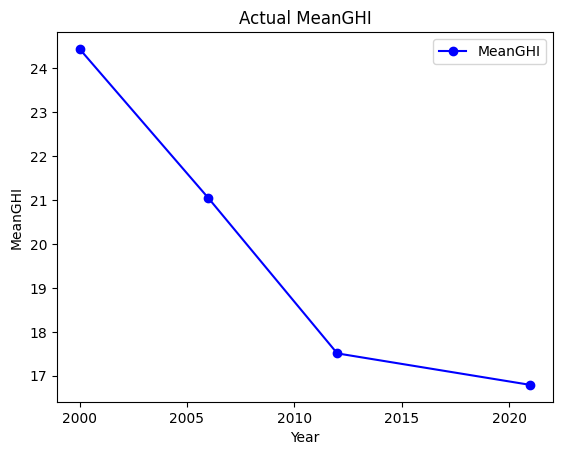

In [23]:
## Plot Initial MeanGHI data
df1=spark.sql("Select * from df_Table order by Year")
#df1.show()
pdf1=df1.toPandas()
pdf1.plot(kind='line', x='Year',y='MeanGHI', linestyle="solid", marker="o", color="blue", title="Actual MeanGHI", xlabel='Year', ylabel='MeanGHI')


## 05-DMM
Data Transform - Process data source to produce Mean values for each year.

<Axes: title={'center': 'Actual/Projected Current'}, xlabel='Year', ylabel='MeanGHI'>

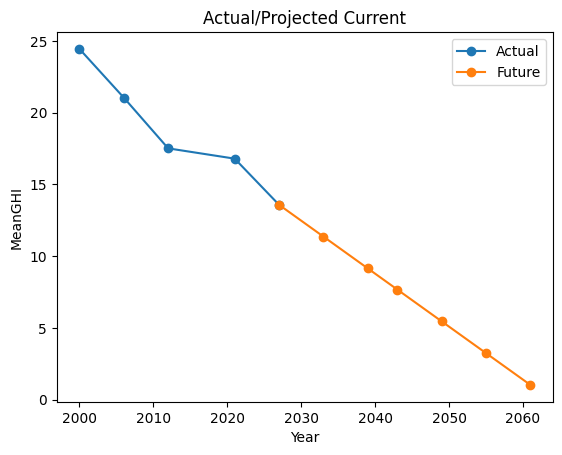

In [24]:
## Data Graphs - Actual/Future

#  Run preduction from full instances collected
df2 = spark.sql("Select Year, MeanGHI from df_Table order by Year limit 4")

X = np.array(df2.select("Year").collect())
Y = np.array(df2.select("MeanGHI").collect())

reg = LinearRegression().fit(X, Y)
reg.score(X, Y)
reg.coef_
reg.intercept_
# Kept adding a year on and rerunning until the value reached/past Zero.
predict_years = [ [2027], [2033], [2039], [2043], [2049], [2055], [2061] ]
future = reg.predict(np.array(predict_years))
#print("Future predictions are %s" % (future))

plotYears = X
plotMeanGHI = Y
#print("xxxx")
#print(plotYears)
#print(plotMeanGHI)
#print("xxxx")

columns = ["Year", "MeanGHI"]
plt_future = df2
plt_1st=plt_future.select("MeanGHI").toPandas().unstack()

x = 4
while x<11:
    plt_1st.loc['MeanGHI', x]=0
    x += 1

new_data = np.column_stack((predict_years, future))
new_row = spark.createDataFrame(new_data.tolist(), schema=columns)
plt_2nd=new_row.select("MeanGHI")
plt_2nd = plt_2nd.toPandas().unstack()

#  Init lower part of dataframe first
x = 7
while x<11:
    #print("Init: %s" % (x))
    plt_2nd.loc['MeanGHI', x]=0
    x += 1

# Rearrange dataframe
x = 10
while x>-1:
    #print("Rearrange: %s" % (x))
    if x<4:
        plt_2nd.loc['MeanGHI',x]=0
    else:
        plt_2nd.loc['MeanGHI',x]=plt_2nd.loc['MeanGHI',(x-4)]
        #print("Value: %s" % (plt_2nd.loc['MeanGHI',(x-4)]))
    x -= 1

# Cross over point
plt_1st.loc['MeanGHI',4]=plt_2nd.loc['MeanGHI',4]

plt_future = plt_future.union(new_row)

#print("....")
#new_row.printSchema()
#new_row.show(truncate=False)
#plt_future.printSchema()
#plt_future.show(truncate=False)
#print("....")

## Plot Initial MeanGHI data
#plt_future.show()
plt_df2=plt_future.toPandas()

#  Convert to series
plt_1st = plt_1st['MeanGHI']
plt_2nd = plt_2nd['MeanGHI']
#print("plt_1st")
#print(plt_1st)
#print("plt_2nd")
#print(plt_2nd)

df5 = pd.DataFrame({'Actual': plt_1st.values,
                    'Future': plt_2nd.values},
                    index=[ 2000, 2006, 2012, 2021, 2027, 2033, 2039, 2043, 2049, 2055, 2061 ])


df5 = df5.replace(0, None)

#print(df5)

df5.plot(kind='line', title="Actual/Projected Current", linestyle="solid", marker="o", xlabel='Year', ylabel='MeanGHI')

In [ ]:
## Working plot for Actual/Future
#  Run preduction from full instances collected
df2 = spark.sql("Select Year, MeanGHI from df_Table order by Year limit 4")

X = np.array(df2.select("Year").collect())
Y = np.array(df2.select("MeanGHI").collect())

reg = LinearRegression().fit(X, Y)
reg.score(X, Y)
reg.coef_
reg.intercept_
# Kept adding a year on and rerunning until the value reached/past Zero.
predict_years = [ [2027], [2033], [2039], [2043], [2049], [2055], [2061] ]
future = reg.predict(np.array(predict_years))
print("The new numbers are %s" % (future))

plotYears = X
plotMeanGHI = Y
print("xxxx")
print(plotYears)
print(plotMeanGHI)
print("xxxx")

columns = ["Year", "MeanGHI"]
plt_future = df2
#plt_1st = np.array(plt_future.select("MeanGHI"))
plt_1st=plt_future.select("MeanGHI").toPandas().unstack()
##columns = ['MeanGHI']
#vals1 = [0, 0, 0, 0, 0, 0, 0]
#val1col = ["MeanGHI"]
#vals1b = spark.createDataFrame([vals1], schema=val1col)
#gg=pd.concat(vals1b, axis=0)
#plt_1st=pd.concat(vals1b)
##plt_1st = plt_1st.shape[-1][1]
#plt_1st.loc['MeanGHI', 4]=0
#plt_1st.loc['MeanGHI', 5]=0
#plt_1st.loc['MeanGHI', 6]=0
#plt_1st.loc['MeanGHI', 7]=0
#plt_1st.loc['MeanGHI', 8]=0
#plt_1st.loc['MeanGHI', 9]=0
#plt_1st.loc['MeanGHI', 10]=0
#plt_1st.loc['MeanGHI', 11]=0

x = 4
while x<11:
    plt_1st.loc['MeanGHI', x]=0
    x += 1

new_data = np.column_stack((predict_years, future))
new_row = spark.createDataFrame(new_data.tolist(), schema=columns)
plt_2nd=new_row.select("MeanGHI")
#plt_2nd = plt_2nd.reshape(-1,1)
plt_2nd = plt_2nd.toPandas().unstack()

#  Init lower part of dataframe first
x = 7
while x<11:
    print("Init: %s" % (x))
    plt_2nd.loc['MeanGHI', x]=0
    x += 1

# Rearrange dataframe
x = 10
while x>-1:
    print("Rearrange: %s" % (x))
    if x<4:
        plt_2nd.loc['MeanGHI',x]=0
    else:
        plt_2nd.loc['MeanGHI',x]=plt_2nd.loc['MeanGHI',(x-4)]
        print("Value: %s" % (plt_2nd.loc['MeanGHI',(x-4)]))
    x -= 1

# Cross over point
plt_1st.loc['MeanGHI',4]=plt_2nd.loc['MeanGHI',4]

#plt_2nd=plt_1st
#plt_2nd['MeanGHI', 0]=0
#plt_2nd['MeanGHI', 1]=0
#plt_2nd['MeanGHI', 2]=0
#plt_2nd.loc[3]=plt_1st['3']
#plt_2nd['MeanGHI', 4]= new_row.MeanGHI[4]
#plt_2nd = plt_2nd.union(new_row)
#plt_2nd=pd.concat(plt_2nda)
#plt_2nd = np.column_stack((plt_2nd, future))

#plt_2nd=new_row.select("MeanGHI").toPandas()
plt_future = plt_future.union(new_row)

print("....")
new_row.printSchema()
new_row.show(truncate=False)
#new_data.printSchema()
#print(new_data)
plt_future.printSchema()
plt_future.show(truncate=False)
print("....")

## Plot Initial MeanGHI data
plt_future.show()
plt_df2=plt_future.toPandas()

#  Convert to series
plt_1st = plt_1st['MeanGHI']
plt_2nd = plt_2nd['MeanGHI']
print("plt_1st")
print(plt_1st)
print("plt_2nd")
print(plt_2nd)

df5 = pd.DataFrame({'length': [1.5, 0.5, 1.2, 0.9, 3],
                  'width': [0.7, 0.2, 0.15, 0.2, 1.1]},
                  index=['pig', 'rabbit', 'duck', 'chicken', 'horse'])

df5 = pd.DataFrame({'Actual': [24.4393, 21.0435, 17.5086, 16.7906, 13.5751, 0, 0, 0, 0, 0, 0 ],
                    'Future': [ 0, 0, 0, 0, 13.57516635514014, 11.3593981308411, 9.14362990654206, 7.666451090342662, 5.450682866043621, 3.234914641744581, 1.0191464174454268]},
                    index=[ '2000', '2006', '2012', '2021', '2027', '2033', '2039', '2043', '2049', '2055', '2061' ])

df5 = pd.DataFrame({'Actual': plt_1st.values,
                    'Future': plt_2nd.values},
                    index=[ 2000, 2006, 2012, 2021, 2027, 2033, 2039, 2043, 2049, 2055, 2061 ])


df5 = df5.replace(0, None)

print(df5)

df5.plot(kind='line', title="Actual/Projected Current", linestyle="solid", marker="o")